# DR16Q Superset Catalogue

[The Sloan Digital Sky Survey Quasar Catalog: sixteenth data release (DR16Q)](https://www.sdss.org/dr16/algorithms/qso_catalog) is available [on the SAS](https://data.sdss.org/sas/dr16/eboss/qso/) and its data model is [online](https://data.sdss.org/datamodel/files/BOSS_QSO/DR16Q/). Code is on [GitHub](https://github.com/bradlyke/dr16q).

> The superset contains 1,440,615 observations of quasars, stars, and galaxies that were all targeted as quasars (or appeared in previous quasar catalogs).

In [1]:
using CSV, DataFrames, DelimitedFiles, FITSIO, HDF5, Statistics, StatsPlots

In [2]:
include("BayesianSZNet.jl")
import .BayesianSZNet

In [3]:
superset_fits = FITS("data/DR16Q_Superset_v3.fits")
superset = DataFrame(
    plate=read(superset_fits[2], "PLATE"),
    mjd=read(superset_fits[2], "MJD"),
    fiberid=read(superset_fits[2], "FIBERID"),
    z=read(superset_fits[2], "Z"),
    source_z=read(superset_fits[2], "SOURCE_Z"),
    z_vi=read(superset_fits[2], "Z_VI"),
    z_conf=read(superset_fits[2], "Z_CONF"),
    z_pipe=read(superset_fits[2], "Z_PIPE"),
    zwarning=read(superset_fits[2], "ZWARNING"),
    z_dr12q=read(superset_fits[2], "Z_DR12Q"),
    z_dr7q_sch=read(superset_fits[2], "Z_DR7Q_SCH"),
    z_dr6q_hw=read(superset_fits[2], "Z_DR6Q_HW"),
    z_10k=read(superset_fits[2], "Z_10K"),
    z_conf_10k=read(superset_fits[2], "Z_CONF_10K"),
    pipe_corr_10k=read(superset_fits[2], "PIPE_CORR_10K"),
    z_pca=read(superset_fits[2], "Z_PCA"),
    z_qn=read(superset_fits[2], "Z_QN"),
    class_person=read(superset_fits[2], "CLASS_PERSON"),
    sn_median_all=read(superset_fits[2], "SN_MEDIAN_ALL"),
    is_qso_final=read(superset_fits[2], "IS_QSO_FINAL"))

,plate,mjd,fiberid,z,source_z,z_vi,z_conf,z_pipe,zwarning
,Int32,Int32,Int16,Float64,String,Float64,Int16,Float64,Int32
1,11279,58449,85,-0.000722127,PIPE,-1.0,0,-0.000722127,0
2,8740,57367,666,-0.000684932,PIPE,-1.0,0,-0.000684932,0
3,7695,57654,574,-0.000839488,PIPE,-1.0,0,-0.000839488,0
4,7850,56956,302,-5.82197e-5,PIPE,-1.0,0,-5.82197e-5,0
5,7750,58402,802,0.845435,PIPE,-1.0,0,0.845435,0
6,6511,56540,892,-0.000611084,PIPE,-1.0,3,-0.000611084,0
7,6511,56540,156,-6.30398e-5,PIPE,-1.0,3,-6.30398e-5,0
8,7147,56574,160,-0.000492124,PIPE,-1.0,3,-0.000492124,0
9,7749,58073,660,2.03549,PIPE,-1.0,0,2.03549,0


> For objects that have a redshift in the columns `Z_VI` or `Z_10K` and a confidence (`Z_CONF` or `Z_CONF_10K`) of ≥ 2, `Z` records the corresponding redshift and `SOURCE_Z` is set to `VI`.
> Otherwise, if an object has a redshift in the columns `Z_DR6Q_HW` or `Z_DR7Q_SCH` these values are used (with `Z_DR6Q_HW` overriding `Z_DR7Q_SCH`) and `SOURCE_Z` is set to `DR6Q_HW` or `DR7QV_SCH`.
> As the `Z_DR7Q_HW` redshifts did not formally appear in the Shen et al. (2011) paper, these values are not used to populate the `Z` column.
> If no other visual inspection redshift is populated then `Z_DR12Q` is used (and `SOURCE_Z` is set to `DR12QV`).
> For objects with DR12Q redshifts, only the visual inspection redshifts are recorded; DR12Q pipeline redshifts  are not included.
> In the absence of any of these visual inspection redshifts, `Z` is populated with the automated pipeline redshift (and `SOURCE_Z` is set to `PIPE`).

> The PCA and `QuasarNET` redshifts are included in their own columns in DR16Q but were not used to inform the Z column.
> Given the heterogeneous source information that is propagated into the Z column, we expect `Z` to represent the least biased redshift estimator, but with a high variance.
> For analyses that require a homogeneous redshift over a large ensemble we recommend `Z_PCA`.
> We ourselves use `Z_PCA in this paper as a redshift prior for calculating absolute i -band magnitudes, and for finding DLAs and BALs (§5).

In [4]:
BayesianSZNet.writelst("data/dr16q_superset.lst", superset.plate, superset.mjd, superset.fiberid)

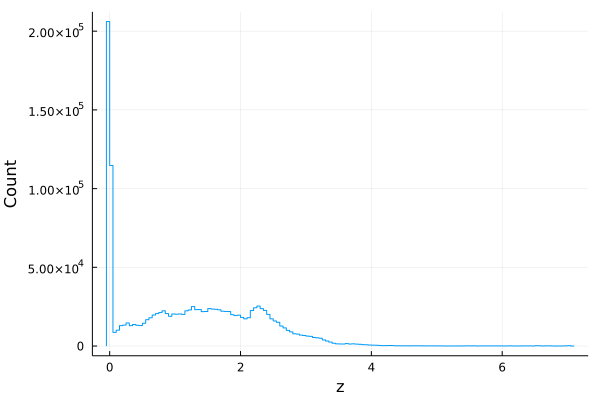

In [5]:
idx_z = superset.z .> -1
@df superset[idx_z, :] histogram(:z, xlabel="z", ylabel="Count", legend=:none)

In [6]:
sum(idx_z), sum(superset.z_vi .> -1)

(1440199, 475194)

## Wavelength Range

In [7]:
specobj_fits = FITS("data/specObj-dr16.fits")
specobj = DataFrame(
    plate=read(specobj_fits[2], "PLATE"),
    mjd=read(specobj_fits[2], "MJD"),
    fiberid=read(specobj_fits[2], "FIBERID"),
    wavemin=read(specobj_fits[2], "WAVEMIN"),
    wavemax=read(specobj_fits[2], "WAVEMAX"))

,plate,mjd,fiberid,wavemin,wavemax
,Int32,Int32,Int32,Float32,Float32
1,266,51602,1,3806.27,9202.38
2,266,51602,2,3806.27,9202.38
3,266,51602,3,3806.27,9202.38
4,266,51602,4,3806.27,9202.38
5,266,51602,5,3805.4,9202.38
6,266,51602,6,3805.4,9202.38
7,266,51602,7,3805.4,9202.38
8,266,51602,8,3805.4,9202.38
9,266,51602,9,3804.52,9202.38


In [8]:
wave_subset = leftjoin(superset, specobj, on=[:plate, :mjd, :fiberid])

,plate,mjd,fiberid,z,source_z,z_vi,z_conf,z_pipe,zwarning,z_dr12q
,Int32,Int32,Int16,Float64,String,Float64,Int16,Float64,Int32,Float64
1,266,51630,3,0.652926,DR6Q_HW,-1.0,-1,-1.0,-1,-1.0
2,266,51630,58,1.47499,DR6Q_HW,-1.0,-1,-1.0,-1,-1.0
3,266,51630,80,1.77284,DR6Q_HW,-1.0,-1,-1.0,-1,-1.0
4,266,51630,126,0.518666,DR6Q_HW,-1.0,-1,-1.0,-1,-1.0
5,266,51630,161,0.325738,DR6Q_HW,-1.0,-1,-1.0,-1,-1.0
6,266,51630,200,0.288773,DR6Q_HW,-1.0,-1,-1.0,-1,-1.0
7,266,51630,208,1.36284,DR6Q_HW,-1.0,-1,-1.0,-1,-1.0
8,266,51630,225,1.62085,DR6Q_HW,-1.0,-1,-1.0,-1,-1.0
9,266,51630,238,1.58165,DR6Q_HW,-1.0,-1,-1.0,-1,-1.0


In [9]:
describe(wave_subset[!, [:wavemin, :wavemax]])

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float32,Float32,Float64,Float32,Int64,Union
1,wavemin,3597.32,3601.64,3601.64,8986.7,42,"Union{Missing, Float32}"
2,wavemax,10202.7,5727.96,10339.5,10396.8,42,"Union{Missing, Float32}"


In [10]:
wave_subset[ismissing.(wave_subset.wavemin), :]

,plate,mjd,fiberid,z,source_z,z_vi,z_conf,z_pipe,zwarning,z_dr12q
,Int32,Int32,Int16,Float64,String,Float64,Int16,Float64,Int32,Float64
1,2865,54497,294,2.4512,DR7QV_SCH,-1.0,-1,-1.0,-1,-1.0
2,2865,54497,435,1.6767,DR7QV_SCH,-1.0,-1,-1.0,-1,-1.0
3,2865,54497,128,1.3937,DR7QV_SCH,-1.0,-1,-1.0,-1,-1.0
4,2865,54497,570,1.3432,DR7QV_SCH,-1.0,-1,-1.0,-1,-1.0
5,2865,54497,141,0.6534,DR7QV_SCH,-1.0,-1,-1.0,-1,-1.0
6,2516,54240,289,1.6467,DR7QV_SCH,-1.0,-1,-1.0,-1,-1.0
7,2516,54240,342,1.4808,DR7QV_SCH,-1.0,-1,-1.0,-1,-1.0
8,2516,54240,346,1.8029,DR7QV_SCH,-1.0,-1,-1.0,-1,-1.0
9,2516,54240,330,1.6509,DR7QV_SCH,-1.0,-1,-1.0,-1,-1.0


In [11]:
subset = dropmissing(wave_subset, [:wavemin, :wavemax])

,plate,mjd,fiberid,z,source_z,z_vi,z_conf,z_pipe,zwarning,z_dr12q
,Int32,Int32,Int16,Float64,String,Float64,Int16,Float64,Int32,Float64
1,266,51630,3,0.652926,DR6Q_HW,-1.0,-1,-1.0,-1,-1.0
2,266,51630,58,1.47499,DR6Q_HW,-1.0,-1,-1.0,-1,-1.0
3,266,51630,80,1.77284,DR6Q_HW,-1.0,-1,-1.0,-1,-1.0
4,266,51630,126,0.518666,DR6Q_HW,-1.0,-1,-1.0,-1,-1.0
5,266,51630,161,0.325738,DR6Q_HW,-1.0,-1,-1.0,-1,-1.0
6,266,51630,200,0.288773,DR6Q_HW,-1.0,-1,-1.0,-1,-1.0
7,266,51630,208,1.36284,DR6Q_HW,-1.0,-1,-1.0,-1,-1.0
8,266,51630,225,1.62085,DR6Q_HW,-1.0,-1,-1.0,-1,-1.0
9,266,51630,238,1.58165,DR6Q_HW,-1.0,-1,-1.0,-1,-1.0


In [12]:
wavemin = quantile(subset.wavemin, 0.999)
wavemax = quantile(subset.wavemax, 0.001)
logwavemin, logwavemax = log10(wavemin), log10(wavemax)
wavemin, wavemax, logwavemin, logwavemax

(3830.0107421875, 9084.478515625, 3.5831999920537956, 3.958300002168358)

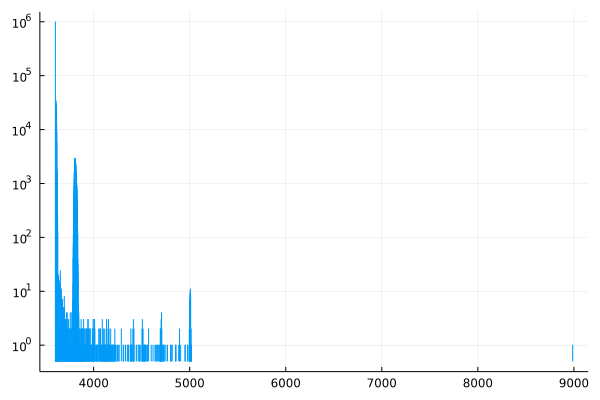

In [13]:
@df subset histogram(:wavemin, legend=:none, yaxis=:log)

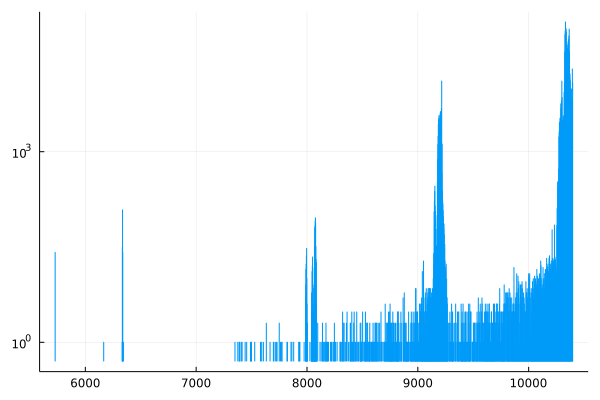

In [20]:
@df subset histogram(:wavemax, legend=:none, yaxis=:log)

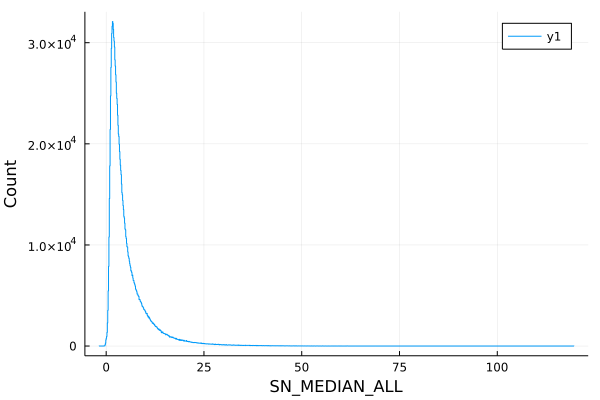

In [14]:
@df subset histogram(:sn_median_all, xlabel="SN_MEDIAN_ALL", ylabel="Count")

## Random Visual Inspection of 10k Spectra

In [15]:
sum(subset.pipe_corr_10k .>= 0), sum(subset.z_10k .> -1)

(10000, 9696)

In [16]:
crossmatch = DataFrame(CSV.File("data/cross_match.csv"))

,plate_dr12q,mjd_dr12q,fiberid_dr12q,ra_dr12q,dec_dr12q,ra_dr16q,dec_dr16q
,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,4296,55499,392,0.132706,1.68575,0.132706,1.68575
2,6110,56279,966,0.410423,21.5518,0.410423,21.5518
3,4216,55477,136,0.592063,-1.14597,0.592063,-1.14597
4,7034,56564,160,0.924004,-4.75996,0.924005,-4.75996
5,4354,55810,885,1.03289,-1.80961,1.03289,-1.80961
6,4534,55863,678,1.18806,9.96837,1.18806,9.96837
7,6879,56539,838,1.29156,23.5631,1.29156,23.5631
8,4354,55810,26,1.35924,-2.91777,1.35924,-2.91777
9,4365,55539,464,1.46355,-3.18467,1.46355,-3.18467


In [17]:
# Remove spectra that were used for training or validation from the 10k index.
n = size(subset, 1)
subset.idx = 1:n
subset_10k = antijoin(
    subset[subset.z_10k .> -1, :], crossmatch,
    on=[:plate => :plate_dr16q, :mjd => :mjd_dr16q, :fiberid => :fiberid_dr16q])
idx_10k = zeros(Bool, n)
idx_10k[subset_10k.idx] .= true
sum(idx_10k)

8668

## HDF5

In [18]:
id = Matrix{Int32}(undef, 3, size(subset, 1))
id[1, :] = subset.plate
id[2, :] = subset.mjd
id[3, :] = subset.fiberid
id

3×1440573 Array{Int32,2}:
   266    266    266    266    266  …   9632   9632   9632   9632   9632
 51630  51630  51630  51630  51630     58130  58130  58130  58130  58130
     3     58     80    126    161       918    936    937    957    972

In [ ]:
# read-write, create file if not existing, preserve existing contents
fid = h5open("data/dr16q_superset.hdf5", "cw")
write_dataset(fid, "id", id)
write_dataset(fid, "z", convert(Vector{Float32}, subset.z))
write_dataset(fid, "source_z", subset.source_z)
write_dataset(fid, "z_vi", convert(Vector{Float32}, subset.z_vi))
write_dataset(fid, "z_pipe", convert(Vector{Float32}, subset.z_pipe))
write_dataset(fid, "zwarning", subset.zwarning)
write_dataset(fid, "z_dr12q", convert(Vector{Float32}, subset.z_dr12q))
write_dataset(fid, "z_dr7q_sch", convert(Vector{Float32}, subset.z_dr7q_sch))
write_dataset(fid, "z_dr6q_hw", convert(Vector{Float32}, subset.z_dr6q_hw))
write_dataset(fid, "z_10k", convert(Vector{Float32}, subset.z_10k))
write_dataset(fid, "pipe_corr_10k", subset.pipe_corr_10k)
write_dataset(fid, "z_pca", convert(Vector{Float32}, subset.z_pca))
write_dataset(fid, "z_qn", convert(Vector{Float32}, subset.z_qn))
write_dataset(fid, "sn_median_all", subset.sn_median_all)
write_dataset(fid, "is_qso_final", subset.is_qso_final)
write_dataset(fid, "idx_10k", idx_10k)
close(fid)